In [467]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = 12, 9
plt.rcParams.update({'font.size': 18})

# Technical Analysis indicators - by Darío López Padial
# https://pythonrepo.com/repo/bukosabino-ta-python-finance
from ta import add_all_ta_features
from ta.utils import dropna
from ta.volatility import BollingerBands
from ta.trend import SMAIndicator, EMAIndicator
from ta.momentum import RSIIndicator

# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [468]:
############################################################################
###################           HELPER FUNCTION             ##################
############################################################################
def fivePercent(row, column):
    incPrice = row['Close']*1.05
    decPrice = row['Close']*0.95
    indices = column[column >= incPrice].index
    priceUpIndex = indices[indices > row.name].min()
    indices = column[column <= decPrice].index
    priceDownIndex = indices[indices > row.name].min()
    
    if (priceDownIndex != priceDownIndex):
        if (priceUpIndex != priceUpIndex):
            return 'none'
        else:
            return 'buy'
        
    if (priceUpIndex != priceUpIndex):
        return 'sell'
    
    if (priceUpIndex < priceDownIndex):
        return 'buy'
    else:
        return 'sell'
 

############################################################################
###################   RANDOM FOREST CLASSIFIER WRAPPER    ##################   
############################################################################
class RandomForest:
    def __init__(self, outcomeName, testSize, dataset, date=None):
        self.outcomeName = outcomeName
        self.testSize = testSize
        self.dataset = dataset
        self.classifier = RandomForestClassifier()
        self.date = date
        
    def split(self, stratify=True):
        if (self.date):
            unixTimestamp = dt.datetime.timestamp(self.date)
            tmpDataset = self.dataset.loc[self.dataset['Unix Timestamp'] <= unixTimestamp]
            self.predictors = tmpDataset.loc[:, tmpDataset.columns != self.outcomeName]
            self.outcome = tmpDataset[self.outcomeName]
        else:
            self.predictors = self.dataset.loc[:, self.dataset.columns != self.outcomeName]
            self.outcome = self.dataset[self.outcomeName]

        if (stratify):
            self.predictorsTrain, self.predictorsTest, self.outcomeTrain, self.outcomeTest = train_test_split(
                self.predictors, self.outcome, test_size=self.testSize, stratify=self.outcome)
        else:
            self.predictorsTrain, self.predictorsTest, self.outcomeTrain, self.outcomeTest = train_test_split(
                self.predictors, self.outcome, test_size=self.testSize)
                
    def trainClassifier(self):
        self.classifier.fit(self.predictorsTrain, self.outcomeTrain)
        
    def evaluateClassifier(self):
        self.predictOutcomeTest = self.classifier.predict(self.predictorsTest)
        self.accuracy = accuracy_score(self.outcomeTest, self.predictOutcomeTest)
        self.confusionMatrix = confusion_matrix(self.outcomeTest, self.predictOutcomeTest)
        print (classification_report(self.outcomeTest, self.predictOutcomeTest))
        
    def printConfusionMatrix(self):
        matrix = self.confusionMatrix.astype('float') / self.confusionMatrix.sum(axis=1)[:, np.newaxis]

        # Build the plot
        plt.figure(figsize=(16,7))
        sns.set(font_scale=1.4)
        sns.heatmap(matrix, annot=True, annot_kws={'size':10},
                    cmap=plt.cm.Greens, linewidths=0.2)

        # Add labels to the plot
        class_names = ['Sell', 'Buy']
        tick_marks = np.arange(len(class_names))
        tick_marks2 = tick_marks + 0.5
        plt.xticks(tick_marks, class_names, rotation=0)
        plt.yticks(tick_marks2, class_names, rotation=0)
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.title('Confusion Matrix for Random Forest Model')
        plt.show()
        
    def predictRow(self, dataRow):
        return self.classifier.predict(dataRow)
    
    def evaluateAlternateData(self):
        unixTimestamp = dt.datetime.timestamp(self.date)
        validationDataset = self.dataset.loc[self.dataset['Unix Timestamp'] > unixTimestamp]
        self.validationSet = validationDataset.loc[:, validationDataset.columns != 'Signal']
        
        predictions = self.predictRow(validationSet)
        incorrect = np.count_nonzero((predictions - np.array(validationDataset['Signal'])))
        total = len(np.array(validationDataset['Signal']))

        return (total - incorrect) / total

    
############################################################################
###################     MANAGE TIME SERIES PRICE DATA     ##################   
############################################################################
class PriceTimeSeries:
    def __init__(self, asset, baseCurrency, timescale, csvFile=None, df=None):
        self.asset = asset
        self.baseCurrency = baseCurrency
        self.timescale = timescale
        if (csvFile):
            self.df = pd.read_csv(csvFile, skiprows=[0])
        else:
            self.df = df
        self.cleanData()
        
    # Any cleaning/initial processing of the data
    def cleanData(self):
        # Force dates to be datetime objects
        self.df['Date'] = pd.to_datetime(self.df['Date'])
        
        # Sort data ascending
        self.df = self.df.sort_values(by=['Date'], ignore_index=True)
        
        # Overwrite Unix Timestamp from Dates to handle s vs ms issue
        self.df['Unix Timestamp'] = self.df.Date.values.astype(np.int64) // 10 ** 9
        
    # Create longer timeframe candles
    # FIXME: There is definitely a more pythonic way to do this...
    def collapse(self, window):
        descOHLC = self.df.sort_values(by=['Date'], ascending=False, ignore_index=True)
        collapsedOHLC = []
        index = 0
        while (index+window-1 <= descOHLC.index[-1]):
            collapseRow = {}
            collapseRow['Unix Timestamp'] = descOHLC.iloc[index+window-1]['Unix Timestamp']
            collapseRow['Date'] = descOHLC.iloc[index+window-1]['Date']
            collapseRow['Symbol'] = descOHLC.iloc[index]['Symbol']
            collapseRow['Open'] = descOHLC.iloc[index+window-1]['Open']
            collapseRow['High'] = descOHLC.iloc[index:index+window]['High'].max()
            collapseRow['Low'] = descOHLC.iloc[index:index+window]['Low'].min()
            collapseRow['Close'] = descOHLC.iloc[index]['Close']
            collapseRow['Volume'] = descOHLC.iloc[index:index+window]['Volume'].sum()
            collapsedOHLC.append(collapseRow)
            index = index + window
            
        return pd.DataFrame(collapsedOHLC)

    # Form a processed dataset that is ready for analysis
    # Drop unnecessary columns, move all columns to numbers, categorical variables -> dummys, etc...
    def formAnalysisDataset(self, dropColumns=['Unix Timestamp', 'Symbol', 'Open', 'High', 'Low'], outcome='FivePercent'):
        self.analysisData = self.df.drop(columns=dropColumns)
        self.analysisData['Unix Timestamp'] = self.analysisData.Date.values.astype(np.int64) // 10** 9
        if (outcome == 'FivePercent'):
            self.analysisData['Signal'] = [1 if (signal == 'buy') else 0 for signal in self.analysisData['FivePercent']]
        if (outcome == 'NextReturnBinary'):
            self.analysisData['Signal'] = [1 if (signal > 0) else 0 for signal in self.analysisData['NextReturn']]
        if (outcome == 'NextReturn'):
            self.analysisData['Signal'] = self.analysisData['NextReturn']
        self.analysisData = self.analysisData.dropna()
        self.analysisData = self.analysisData[self.analysisData != 'none']
        self.analysisData = self.analysisData.drop(['Date','NextReturn','FivePercent'], axis=1)
        self.analysisData = self.analysisData.reset_index(drop=True)
            
    # Add simple returns calculation
    def addArithmeticReturns(self):
        columnName = 'Return'
        self.df[columnName] = (self.df['Close'] - self.df['Close'].shift(1))/self.df['Close'].shift(1)
        
    # Add logarithmic returns calculation (https://quantivity.wordpress.com/2011/02/21/why-log-returns/)
    def addLogReturns(self):
        columnName = 'logReturn'
        self.df[columnName] = np.log(self.df['Close'] / self.df['Close'].shift(1))
        
    # Add Relative Price Range (Used in Sebastiao and Godinho 2021)
    def addRRt(self):
        columnName = 'RRt'
        self.df[columnName] = 2.0*(self.df['High'] - self.df['Low']) / (self.df['High'] + self.df['Low'])
        
    # Add Parkinson Volatility Estimator (Used in Sebastiao and Godinho 2021 from Parkinson 1980)    
    def addParkVol(self):
        columnName = 'sigmat'
        self.df[columnName] = np.sqrt((np.log(self.df['High']/self.df['Low'])**2)/(4.0 * np.log(2)))
    
    # Add Simple Moving Average Indicator for desired timeframe
    def addSMA(self, window):
        columnName = "SMA-" + str(window)
        self.df[columnName] = SMAIndicator(close=self.df['Close'], window=window, fillna=False).sma_indicator()
        
        columnName2 = "dSMA-" + str(window) + "dt"
        self.df[columnName2] = (self.df[columnName] - self.df[columnName].shift(1))
        
        columnName3 = "d2SMA-" + str(window) + "dt2"
        self.df[columnName3] = (2*self.df[columnName] - 5*self.df[columnName].shift(1) + 4*self.df[columnName].shift(2) - self.df[columnName].shift(3))       

        columnName4 = "SMA-" + str(window) + "-deviation"
        self.df[columnName4] = (self.df['Close'] - self.df[columnName]) / self.df[columnName]
        
    # Add Exponential Moving Average Indicator for desired timeframe
    def addEMA(self, window):
        columnName = "EMA-" + str(window)
        self.df[columnName] = EMAIndicator(close=self.df['Close'], window=window, fillna=False).ema_indicator()

        columnName2 = "dEMA-" + str(window) + "dt"
        self.df[columnName2] = (self.df[columnName] - self.df[columnName].shift(1))
        
        columnName3 = "d2EMA-" + str(window) + "dt2"
        self.df[columnName3] = (2*self.df[columnName] - 5*self.df[columnName].shift(1) + 4*self.df[columnName].shift(2) - self.df[columnName].shift(3))       

        columnName4 = "EMA-" + str(window) + "-deviation"
        self.df[columnName4] = (self.df['Close'] - self.df[columnName]) / self.df[columnName]
        
    # Add Relative Strength Index 
    # default = 14 time units
    def addRSI(self, window=14):
        columnName = "RSI-" + str(window)
        self.df[columnName] = RSIIndicator(close=self.df['Close'], window=window, fillna=False).rsi()

    # Add Bollinger Bands Hi and Low Values 
    # default = 20 time units, 2 standard deviations
    def addBB(self, window=20, stDev=2):
        bbData = BollingerBands(close=self.df['Close'], window=window, window_dev=stDev, fillna=False)

        columnName = "BB-" + str(window) + "-" + str(stDev) + "-hi"
        self.df[columnName] = bbData.bollinger_hband()
        columnName = "BB-" + str(window) + "-" + str(stDev) + "-low"
        self.df[columnName] = bbData.bollinger_lband()
        columnName = "BB-" + str(window) + "-" + str(stDev) + "-width"
        self.df[columnName] = bbData.bollinger_hband() - bbData.bollinger_lband()
        
    def createRandomForest(self, outcomeColumn='Signal', testSize=0.1, date=None):
        if (self.analysisData.empty):
            self.formAnalysisDataset()
            self.randomForest = RandomForest(outcomeColumn, testSize, self.analysisData, date)
        else:
            self.randomForest = RandomForest(outcomeColumn, testSize, self.analysisData, date)
        
    # Add different ways to assess if this should of been a buy or sell    
    def addEvals(self):
        # Option 1: If next candle is up, should of bought, if next candle down, should of sold
        # >0 --> "Buy", <0 --> "Sell" *** Keep raw value here, will map sign to Buy/Sell later
        columnName = "NextReturn"
        self.df[columnName] = (self.df['Close'].shift(-1) - self.df['Close'])/self.df['Close']
        
        # Option 2: Does close price go up 5% or down 5% first
        columnName = "FivePercent"
        self.df[columnName] = self.df.apply(fivePercent, axis=1, args=[self.df['Close']]) 
    
        
############################################################################
###################         STRATEGY BASE CLASS           ##################   
############################################################################
class Strategy:
    def __init__(self, history=1):
        self.historyNeeded = history
    
    def apply(self, df, ledger=None):
        pass

    
############################################################################
###################        BACKTESTING FRAMEWORK          ##################   
############################################################################
class Backtest:
    def __init__(self, priceDataFrame, initialValue=10000, unitPrice=100, tradeFeePct=0.0, logging=True):
        self.strategies = {}
        self.priceData = priceDataFrame
        self.initialValue = initialValue
        self.value = initialValue
        self.unitPrice = unitPrice
        self.amount = 0.0
        self.tradingFeePct = tradeFeePct/100
        self.startDate = self.priceData.Date.min()
        self.endDate = self.priceData.Date.max()
        
        # Turn ledger off if needed
        self.ledger = []
        self.log = logging
        
    def restrictDates(self, startDate=None, endDate=None):
        # Set backtesting start/end dates
        if (startDate): self.endDate = startDate          
        if (endDate): self.endDate = endDate
            
        # Restrict priceData to only desired backtesting timeframe
        self.priceData = self.priceData.loc[((self.priceData.Date >= startDate) & 
                                             (self.priceData.Date <= endDate))]
        self.priceData = self.priceData.reset_index()
        
    def evaluateStrategy(self, strategy, name=None, passLedger=False):
        for index, row in self.priceData.iterrows():
            #print ('BEGIN STRATEGY LOOP')
            #print (index, row['Date'], row['Open'], row['Close'], row['RSI-14'])
            strategyFrame = self.priceData.iloc[index-strategy.historyNeeded:index]
            if (len(strategyFrame) == strategy.historyNeeded):
                if (passLedger):
                    if (name):
                        #print ('HERE!')
                        signal, size = strategy.apply(self.priceData.iloc[index+1-strategy.historyNeeded:index+1], 
                                                ledger=self.ledger, unitPrice=self.unitPrice)
                    else:
                        signal, size = strategy.apply(self.priceData.iloc[index+1-strategy.historyNeeded:index+1], 
                                                ledger=self.ledger, unitPrice=self.unitPrice)
                else:
                    signal, size = strategy.apply(self.priceData.iloc[index+1-strategy.historyNeeded:index+1], 
                                            ledger=None, unitPrice=self.unitPrice)
                
                if (signal == 'buy'):
                    #print (size, row['Close'], self.unitPrice, size*row['Close']/self.unitPrice)
                    self.buyAsset(size*row['Close']/self.unitPrice, row['Close'], row['Date'])
                elif (signal == 'sell'):
                    self.sellAsset(size*row['Close']/self.unitPrice, row['Close'], row['Date'])

            #print ('END STRATEGY LOOP')
              
            
        # Liquidate all assets once you've reached the end
        self.sellAsset(1e8, self.priceData.iloc[-1]['Close'], 
                       self.priceData.iloc[-1]['Date'] + dt.timedelta(hours=1))
        
        # Store strategy outcome
        if (name):
            self.strategies[name] = {'P/L': self.value - self.initialValue, 'log': self.ledger}
            if (self.log):
                self.strategies[name]['log'] = pd.DataFrame(self.strategies[name]['log'])
        else:
            self.strategies[strategy] = {'P/L': self.value - self.initialValue, 'log': self.ledger}
            if (self.log):
                self.strategies[strategy]['log'] = pd.DataFrame(self.strategies[strategy]['log'])
            
        # Reset testing regime
        self.value = self.initialValue
        self.ledger = []
        self.amount = 0.0
        
    def pltStrategy(self, name):
        logDF = pd.DataFrame(self.strategies[name]['log'])
        logDF = self.priceData[['Date','Close']].merge(logDF, how='outer')
        logDF = logDF.fillna(method='ffill').fillna(method='bfill')
        PandL = self.strategies[name]['P/L']
        vertLoc = logDF['PortfolioCash'].min() + (10000 - logDF['PortfolioCash'].min())/3

        fig, axs = plt.subplots(2,1, gridspec_kw={'height_ratios': [3, 1]})
        axs[0].plot(logDF['Date'],logDF['PortfolioValue'], color='red', label='Portfolio Value', linewidth=3)
        axs[0].plot(logDF['Date'],logDF['PortfolioCash'], color='blue', label='Cash on Hand', linewidth=3)
        axs[0].text(dt.datetime(2021,2,9), vertLoc, 'P/L: $' + str(round(PandL,2)), color='gray')
        axs[0].legend()
        axs[1].plot(logDF['Date'],logDF['Close'], color='k', label='Price', linewidth=2)
        axs[1].legend()
        plt.show()
    
    def buyAsset(self, units, price, date):
        # Set the buy amount
        buySize = min(self.value, units*self.unitPrice)
        if (buySize > 0.0):
            # Remove buy amount from portfolio value
            self.value -= buySize
            # Increase how much of the asset I own, accounting for trading fee
            self.amount += (1.0-self.tradingFeePct)*buySize/price
            
        if (self.log): self.ledger.append({'Action': 'Buy', 
                                           'Spent': buySize,
                                           'Acquired': (1.0-self.tradingFeePct)*buySize/price,
                                           'Date': date,
                                           'PortfolioValue': self.value + self.amount*price*(1.0-self.tradingFeePct),
                                           'PortfolioCash': self.value,
                                           'PortfolioAmount': self.amount,
                                           'Note': 'Buy ' + str((1.0-self.tradingFeePct)*buySize/price) + ' for $' + str(buySize) + ' || acct: ' + str(self.value) + ' asset: ' + str(self.amount)
                                          })
                                          
    def sellAsset(self, units, price, date):
        # Set the sell amount
        sellSize = min(self.amount, units*self.unitPrice/price)
        if (sellSize > 0.0):
            # Increase portfolio value due to sale, accounting for trading fee
            self.value += sellSize*price*(1.0-self.tradingFeePct)
            # Decrease how much of the asset I own
            self.amount -= sellSize    
            
        if (self.log): self.ledger.append({'Action': 'Sell', 
                                           'Received': sellSize*price*(1.0-self.tradingFeePct),
                                           'Disposed': sellSize,
                                           'Date': date,
                                           'PortfolioValue': self.value + self.amount*price*(1.0-self.tradingFeePct),
                                           'PortfolioCash': self.value,
                                           'PortfolioAmount': self.amount,
                                           'Note': 'Sell ' + str(sellSize) + ' for $' + str(sellSize*price*(1.0-self.tradingFeePct)) + ' || acct: ' + str(self.value) + ' asset: ' + str(self.amount)
                                          })

In [469]:
############################################################################
##################            CREATE DATASETS             ##################   
############################################################################
# Read in BTC/ETH/LTC csv data and instantiate some classes
btc1H = PriceTimeSeries('BTC', 'USD', '1H', csvFile='gemini_BTCUSD_1hr.csv')
eth1H = PriceTimeSeries('ETH', 'USD', '1H', csvFile='gemini_ETHUSD_1hr.csv')
ltc1H = PriceTimeSeries('LTC', 'USD', '1H', csvFile='gemini_LTCUSD_1hr.csv')

btc4H = PriceTimeSeries('BTC', 'USD', '4H', df=btc1H.collapse(4))
btc1D = PriceTimeSeries('BTC', 'USD', '1D', df=btc1H.collapse(24))
#btc1W = PriceTimeSeries('BTC', 'USD', '1W', df=btc1H.collapse(168))

eth4H = PriceTimeSeries('ETH', 'USD', '4H', df=eth1H.collapse(4))
eth1D = PriceTimeSeries('ETH', 'USD', '1D', df=eth1H.collapse(24))
#eth1W = PriceTimeSeries('ETH', 'USD', '1W', df=eth1H.collapse(168))

ltc4H = PriceTimeSeries('LTC', 'USD', '4H', df=ltc1H.collapse(4))
ltc1D = PriceTimeSeries('LTC', 'USD', '1D', df=ltc1H.collapse(24))
#ltc1W = PriceTimeSeries('LTC', 'USD', '1W', df=ltc1H.collapse(168))

# Add some basic TA indicators/quantities
for asset in [btc1H, eth1H, ltc1H, btc4H, eth4H, ltc4H, btc1D, eth1D, ltc1D]: #, btc1W, eth1W, ltc1W]:
    print ('Working on processing', asset.asset, asset.timescale, '...')
    asset.addArithmeticReturns()
    asset.addLogReturns()
    asset.addRSI()
    asset.addBB()
    asset.addRRt()
    asset.addParkVol() 
    for window in [5,10,20,50,100,200]:
        asset.addSMA(window) 
        asset.addEMA(window)
        
    asset.addEvals()    
    asset.formAnalysisDataset(outcome='NextReturn')

    asset.createRandomForest(outcomeColumn='Signal', testSize=0.1, date=dt.datetime(2021,2,1))
    asset.randomForest.split(stratify=False)
    #asset.randomForest.trainClassifier()

Working on processing BTC 1H ...
Working on processing ETH 1H ...
Working on processing LTC 1H ...
Working on processing BTC 4H ...
Working on processing ETH 4H ...
Working on processing LTC 4H ...
Working on processing BTC 1D ...
Working on processing ETH 1D ...
Working on processing LTC 1D ...


In [451]:
############################################################################
##################         IMPLEMENT STRATEGIES           ##################   
############################################################################
# Super basic strategy to serve as baseline
# If price is up this hour, buy, if price is down, sell
class naive(Strategy):
    def __init__(self):
        self.historyNeeded = 2
        
    def apply(self, df, ledger=None, unitPrice=100.0):
        if (df.iloc[0].Close < df.iloc[1].Close):
            return 'buy', unitPrice/df.iloc[0]['Close']
        elif (df.iloc[0].Close > df.iloc[1].Close):
            return 'sell', unitPrice/df.iloc[0]['Close']
        else:
            return 'none', 0

class naiveTA(Strategy):
    def apply(self, df, ledger=None, unitPrice=100.0):
        # SMA Signals
        if (df.iloc[0]['Close'] > df.iloc[0]['SMA-5']):
            return 'buy', unitPrice/df.iloc[0]['Close']
        elif (df.iloc[0]['Close'] < df.iloc[0]['SMA-5']):
            return 'sell', unitPrice/df.iloc[0]['Close'] 
        else:
            return 'none', 0
        
class RSI(Strategy):    
    def apply(self, df, ledger=None, unitPrice=100.0):
        # RSI Signals
        if ((df.iloc[0]['RSI-14'] < 30.0) and (df.iloc[0]['Close'] < df.iloc[0]['SMA-50'])):
            return 'buy', unitPrice/df.iloc[0]['Close']
        elif ((df.iloc[0]['RSI-14'] > 70.0) and (df.iloc[0]['Close'] > df.iloc[0]['SMA-50'])):
            return 'sell', unitPrice/df.iloc[0]['Close'] 
        else:
            return 'none', 0

class RegressionModel(Strategy):
    def apply(self, df, ledger=None, unitPrice=100.0):
        ### -0.0079 + 0.0000007548*Volume + 0.0002*RSI-14 - 0.0611*EMA-20-deviation + 
        ###  0.00001388dSMA-5dt -0.0520logReturn
        predictedReturn = -0.0079
        predictedReturn += 0.0000007548*df.iloc[0]['Volume']
        predictedReturn += 0.0002*df.iloc[0]['RSI-14']
        predictedReturn -= 0.0611*df.iloc[0]['EMA-20-deviation']
        predictedReturn += 0.00001388*df.iloc[0]['dSMA-5dt']
        predictedReturn -= 0.0520*df.iloc[0]['logReturn']
        
        if (predictedReturn >= 0.01):
            return 'buy', unitPrice/df.iloc[0]['Close']
        elif (predictedReturn <= -0.01):
            return 'sell', unitPrice/df.iloc[0]['Close']
        else:
            return 'none', 0
        
class RSIFivePercent(Strategy):   
    def __init__(self):
        self.historyNeeded = 1
        self.internalLedger = {}
        
    def apply(self, df, ledger=None, unitPrice=100.0):
        #display (df)
        currentPrice = df.iloc[0].Close
        #display (ledger)
        sellAmount = self.updateInternalLedger(ledger, currentPrice)
        
        # RSI Signals
        if ((df.iloc[0]['RSI-14'] < 30.0) and (df.iloc[0]['Close'] < df.iloc[0]['SMA-50'])):
            initialSignal = 'buy'
        elif ((df.iloc[0]['RSI-14'] > 70.0) and (df.iloc[0]['Close'] > df.iloc[0]['SMA-50'])):
            initialSignal = 'sell' 
        else:
            initialSignal = 'none'

        #print (currentPrice, sellAmount, initialSignal, df.iloc[0]['RSI-14'], df.iloc[0]['Close']-df.iloc[0]['SMA-50'])
        
        if (sellAmount > 0):
            return 'sell', sellAmount
        elif (initialSignal == 'buy'):
            return 'buy', unitPrice/currentPrice
        else:
            return 'none', 0
    
    def updateInternalLedger(self, ledger, currentPrice):
        if (ledger):
            #print ('In here')
            #display (ledger)
            lastEntryDate = ledger[-1]['Date']
            lastEntryAction = ledger[-1]['Action']
            if (lastEntryDate not in self.internalLedger):
                if (lastEntryAction == 'Buy'):
                    buySize = ledger[-1]['Acquired']
                    buyCost = ledger[-1]['Spent']
                    self.internalLedger[lastEntryDate] = {'Amount': buySize, 'Price': buyCost/buySize,
                                                          'Stop': buyCost/buySize*0.95, 'openDate': lastEntryDate,
                                                          'Target': buyCost/buySize*1.05, 'Status': 'Open'}

            ledgerDataFrame = pd.DataFrame.from_dict(self.internalLedger, orient='index')
            #display (ledgerDataFrame)
            ledgerDataFrame = ledgerDataFrame.loc[ledgerDataFrame.Status == 'Open']
            hitStopPrice = ledgerDataFrame.loc[ledgerDataFrame.Stop >= currentPrice]
            hitTargetPrice = ledgerDataFrame.loc[ledgerDataFrame.Target <= currentPrice]

            totalSell = 0.0
            if (not hitStopPrice.empty):
                for index, sell in hitStopPrice.iterrows():
                    self.internalLedger[sell['openDate']]['Status'] = 'Closed'
                    totalSell += sell['Amount'] 

            if (not hitTargetPrice.empty):
                for index, update in hitTargetPrice.iterrows():
                    self.internalLedger[update['openDate']]['Target'] = currentPrice
                    self.internalLedger[update['openDate']]['Stop'] = currentPrice*0.95

            return totalSell
        
        else:
            return 0.0
        
                
class ReverseRSI(Strategy):    
    def apply(self, df, ledger=None, unitPrice=100.0):
        # RSI Signals
        if ((df.iloc[0]['RSI-14'] < 30.0) and (df.iloc[0]['Close'] < df.iloc[0]['SMA-50'])):
            return 'sell', unitPrice/df.iloc[0]['Close']
        elif ((df.iloc[0]['RSI-14'] > 70.0) and (df.iloc[0]['Close'] > df.iloc[0]['SMA-50'])):
            return 'buy', unitPrice/df.iloc[0]['Close'] 
        else:
            return 'none', 0
        

# FIXME: This seems clunky, maybe classes aren't the best thing for strategies?
naive = naive()
naiveTA = naiveTA()
RSI = RSI()
rRSI = ReverseRSI()
RSIFive = RSIFivePercent()
Regression = RegressionModel()
#Bollinger = Bollinger()

In [454]:
############################################################################
###########      SETUP BACKTESTING FRAMEWORKS FOR DATASETS     #############   
############################################################################
strtDate = dt.datetime(2021,2,1)
finsDate = dt.datetime(2021,9,30)

identifier = '7M'
bcktsts = {}
for bcktst in [btc1H, btc4H, btc1D, eth1H, eth4H, eth1D, ltc1H, ltc4H, ltc1D]:
    name = bcktst.asset + bcktst.timescale + identifier
    bcktsts[name + '0F'] = Backtest(bcktst.df, initialValue=10000, unitPrice=100, tradeFeePct=0.0, logging=True)
    bcktsts[name + '0F'].restrictDates(startDate=strtDate, endDate=finsDate)

    bcktsts[name + '5F'] = Backtest(bcktst.df, initialValue=10000, unitPrice=100, tradeFeePct=0.5, logging=True)
    bcktsts[name + '5F'].restrictDates(startDate=strtDate, endDate=finsDate)

In [455]:
############################################################################
########     EVALUATE STRATEGY PERFORMANCE THROUGH BACKTESTING     #########   
############################################################################
for key, backtst in bcktsts.items():
    print ('Evaluating', key, '...')
    backtst.evaluateStrategy(naive, 'NaiveStrategy')
    backtst.evaluateStrategy(naiveTA, 'TA-Naive')
    backtst.evaluateStrategy(RSI, 'RSI')
    backtst.evaluateStrategy(rRSI, 'Reverse-RSI')
    backtst.evaluateStrategy(RSIFive, 'RSI-FivePercent', passLedger=True)
    backtst.evaluateStrategy(Regression, 'RegressionModel')

Evaluating BTC4H7M0F ...
Evaluating BTC4H7M5F ...
Evaluating BTC1D7M0F ...
Evaluating BTC1D7M5F ...
Evaluating ETH4H7M0F ...
Evaluating ETH4H7M5F ...
Evaluating ETH1D7M0F ...
Evaluating ETH1D7M5F ...
Evaluating LTC4H7M0F ...
Evaluating LTC4H7M5F ...
Evaluating LTC1D7M0F ...
Evaluating LTC1D7M5F ...


In [ ]:
        ####################################################
        ####################################################
        #####   SCRATCH WORK AND ANALYSIS BELOW HERE   #####
        ####################################################
        ####################################################

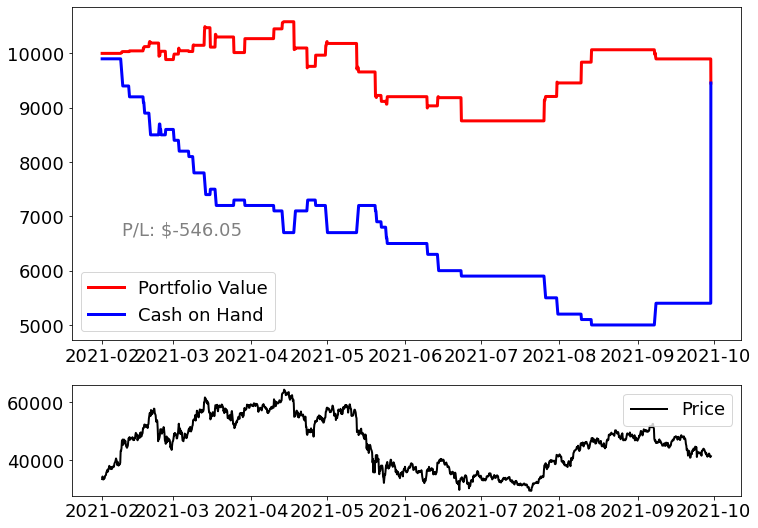

In [466]:
bcktsts['BTC4H7M0F'].pltStrategy('RegressionModel')

#pd.DataFrame(btc1H6M0F.strategies['NaiveStrategy']['log']).plot(x='Date',y='PortfolioValue')
#pd.DataFrame(btc1H6M0F.strategies['TA-Naive']['log']).plot(x='Date',y='PortfolioValue')
#pd.DataFrame(btc1H6M0F.strategies['RSI']['log']).plot(x='Date',y='PortfolioValue')

In [461]:
bcktsts['BTC4H7M0F'].strategies['RegressionModel']['log'][0:60]

,Action,Spent,Acquired,Date,PortfolioValue,PortfolioCash,PortfolioAmount,Note,Received,Disposed
0,Buy,100.0,0.002459,2021-02-06 13:00:00,10000.000000,9900.0,0.002459,Buy 0.0024585416127836297 for $100.0 || acct: ...,NaN,NaN
1,Buy,100.0,0.002310,2021-02-08 13:00:00,10006.414237,9800.0,0.004769,Buy 0.00231035027682617 for $100.0 || acct: 98...,NaN,NaN
2,Buy,100.0,0.002260,2021-02-08 17:00:00,10010.999955,9700.0,0.007029,Buy 0.00226013881320563 for $100.0000000000000...,NaN,NaN
3,Buy,100.0,0.002138,2021-02-08 21:00:00,10028.830427,9600.0,0.009167,Buy 0.002137585246899646 for $100.0 || acct: 9...,NaN,NaN
4,Buy,100.0,0.002134,2021-02-09 01:00:00,10029.452932,9500.0,0.011301,Buy 0.0021344867530550377 for $100.0 || acct: ...,NaN,NaN
5,Buy,100.0,0.002119,2021-02-09 05:00:00,10033.376562,9400.0,0.013420,Buy 0.0021187850208679135 for $100.0 || acct: ...,NaN,NaN
6,Buy,100.0,0.002122,2021-02-11 17:00:00,10032.564793,9300.0,0.015541,Buy 0.0021215040530274186 for $100.00000000000...,NaN,NaN
7,Buy,100.0,0.002083,2021-02-11 21:00:00,10046.143618,9200.0,0.017624,Buy 0.0020828954913435912 for $100.00000000000...,NaN,NaN
8,Buy,100.0,0.001960,2021-02-17 09:00:00,10099.191841,9100.0,0.019584,Buy 0.001960014143462059 for $99.9999999999999...,NaN,NaN
9,Buy,100.0,0.001913,2021-02-17 17:00:00,10123.627370,9000.0,0.021498,Buy 0.0019132256506162978 for $100.0 || acct: ...,NaN,NaN


<AxesSubplot:xlabel='Date'>

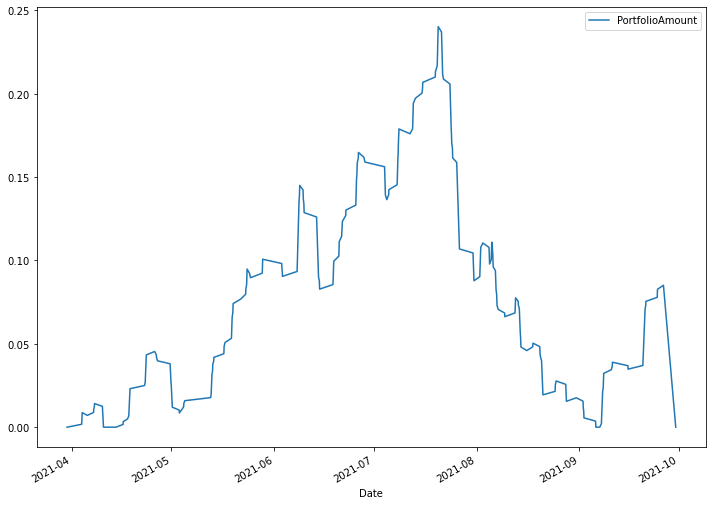

In [336]:
pd.DataFrame(btc1H6M0F.strategies['RSI']['log']).plot(x='Date',y='PortfolioAmount')

In [335]:
btc1H6M0F.strategies['RSI']['log']

,Action,Received,Disposed,Date,PortfolioValue,PortfolioCash,PortfolioAmount,Note,Spent,Acquired
0,Sell,0.000000,0.000000,2021-03-30 12:00:00,10000.000000,10000.000000,0.000000,Sell 0.0 for $0.0 || acct: 10000 asset: 0.0,NaN,NaN
1,Sell,0.000000,0.000000,2021-03-30 13:00:00,10000.000000,10000.000000,0.000000,Sell 0.0 for $0.0 || acct: 10000 asset: 0.0,NaN,NaN
2,Buy,NaN,NaN,2021-04-03 22:00:00,10000.000000,9900.000000,0.001737,Buy 0.001736596212379465 for $100 || acct: 990...,100.0,0.001737
3,Buy,NaN,NaN,2021-04-03 23:00:00,9999.174457,9800.000000,0.003488,Buy 0.0017510519006530198 for $100 || acct: 98...,100.0,0.001751
4,Buy,NaN,NaN,2021-04-04 00:00:00,9997.692799,9700.000000,0.005252,Buy 0.0017641755919250155 for $100 || acct: 97...,100.0,0.001764
...,...,...,...,...,...,...,...,...,...,...
437,Buy,NaN,NaN,2021-09-24 11:00:00,11382.206883,8146.359507,0.077870,Buy 0.0024064718691861144 for $100 || acct: 81...,100.0,0.002406
438,Buy,NaN,NaN,2021-09-24 12:00:00,11353.208965,8046.359507,0.080298,Buy 0.0024282323779533984 for $100 || acct: 80...,100.0,0.002428
439,Buy,NaN,NaN,2021-09-24 13:00:00,11408.623410,7946.359507,0.082686,Buy 0.0023882119767397706 for $100 || acct: 79...,100.0,0.002388
440,Buy,NaN,NaN,2021-09-26 08:00:00,11387.830311,7846.359507,0.085089,Buy 0.00240264136781412 for $100 || acct: 7846...,100.0,0.002403


In [443]:
#fftClose = np.fft.rfft(np.array(btc.df.Close))

RSIsearch = dset.df[['Close',sma,'RSI-14']]
RSIsearch['FutureSMA'] = RSIsearch[sma].shift(-50)

conditions = [RSIsearch['Close'] > RSIsearch['FutureSMA'], RSIsearch['Close'] <= RSIsearch['FutureSMA']]
classifier = [-1,1]
RSIsearch['Classifier'] = np.select(conditions, classifier, default=0)
RSIsearch['CorrectSignal'] = ["Buy" if signal == 1 else "Sell" for signal in RSIsearch["Classifier"]]
RSIsearch['SMAdeviation'] = (RSIsearch['Close'] - RSIsearch[sma])/RSIsearch[sma]

conditions = [((RSIsearch['SMAdeviation'] > 0.0) & (RSIsearch['RSI-14'] < 30)), 
              ((RSIsearch['SMAdeviation'] > 0.0) & (RSIsearch['RSI-14'] > 70)),
              ((RSIsearch['SMAdeviation'] > 0.0) & (RSIsearch['RSI-14'] >= 30) & (RSIsearch['RSI-14'] <= 70)),
              ((RSIsearch['SMAdeviation'] <= 0.0) & (RSIsearch['RSI-14'] < 30)),
              ((RSIsearch['SMAdeviation'] <= 0.0) & (RSIsearch['RSI-14'] > 70)),
              ((RSIsearch['SMAdeviation'] <= 0.0) & (RSIsearch['RSI-14'] >= 30) & (RSIsearch['RSI-14'] <= 70))]
classifier = ['6','2','4','5','1','3']
RSIsearch['Quadrant'] = np.select(conditions, classifier, default='-1')

RSIsearch.groupby(['Quadrant','CorrectSignal']).count()

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Close  SMA-50  RSI-14  FutureSMA  Classifier  \
Quadrant CorrectSignal                                                 
-1       Buy               44       0      35         44          44   
         Sell               5       0       1          5           5   
2        Buy             2731    2731    2731       2731        2731   
         Sell            2016    2016    2016       2016        2016   
3        Buy            11439   11439   11439      11439       11439   
         Sell            8947    8947    8947       8900        8947   
4        Buy            13577   13577   13577      13577       13577   
         Sell           11123   11123   11123      11120       11123   
5        Buy             1435    1435    1435       1435        1435   
         Sell            1084    1084    1084       1084        1084   

                        SMAdeviation  
Quadrant CorrectSignal                
-1       Buy                       0  
         Sell                      0  
2        Buy                    2731  
         Sell                   2016  
3        Buy                   11439  
         Sell                   8947  
4        Buy                   13577  
         Sell                  11123  
5        Buy                    1435  
         Sell                   1084

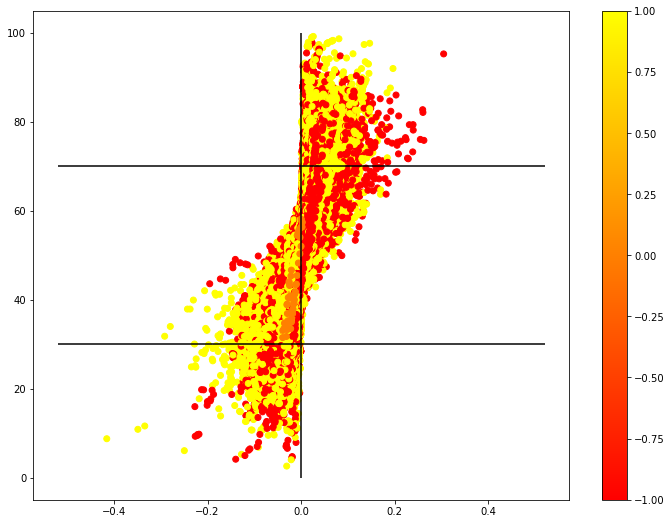

In [446]:
dset = btc1H
sma = 'SMA-50'

# Let's build a simple RSI strategy
# We are interested in key values of the RSI when the various SMA's are trending up/down

# Let's investigate through some plots
plt.scatter(RSIsearch['SMAdeviation'], RSIsearch['RSI-14'], c=RSIsearch['Classifier'], cmap='autumn')
plt.colorbar()
plt.hlines(30,-0.52,0.52, color='k')
plt.hlines(70,-0.52,0.52, color='k')
plt.vlines(0,0,100, color='k')
plt.show()

In [4]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

/usr/local/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(0.0, 30.0)

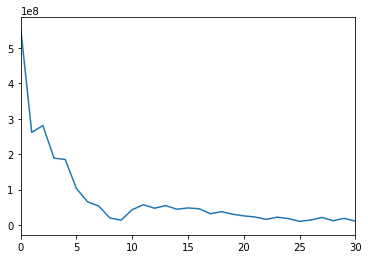

In [7]:
import matplotlib.pyplot as plt

plt.plot(np.sqrt(fftClose*np.conj(fftClose)))
plt.xlim([0,30])

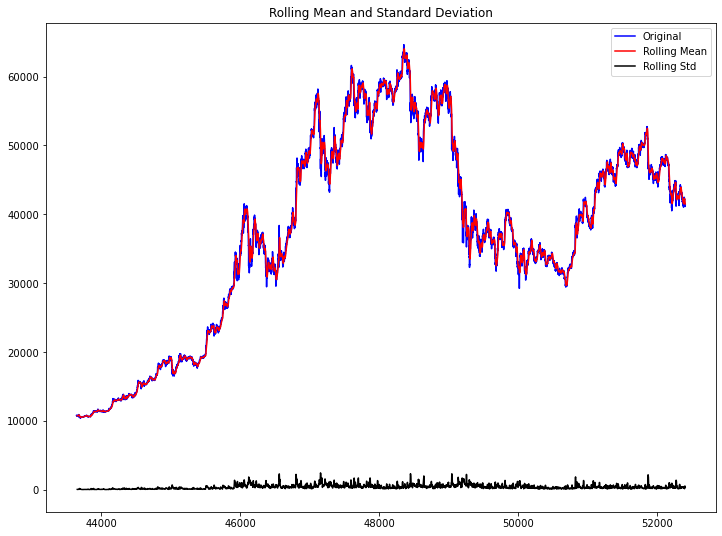

Results of dickey fuller test
Test Statistics                  -1.830235
p-value                           0.365558
No. of lags used                 35.000000
Number of observations used    8724.000000
critical value (1%)              -3.431100
critical value (5%)              -2.861871
critical value (10%)             -2.566946
dtype: float64


In [88]:
plt.rcParams['figure.figsize'] = 12, 9
df_close = btc.df['Close'][-24*365:]
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_close)

<Figure size 864x648 with 0 Axes>

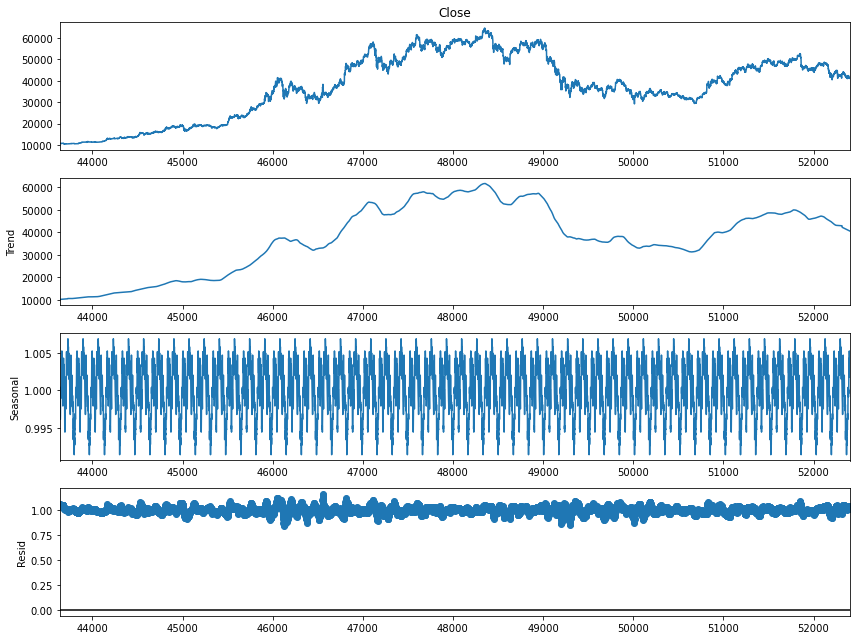

In [447]:
result = seasonal_decompose(df_close, model='multiplicative', period = 24*7, extrapolate_trend='freq')
fig = plt.figure()  
fig = result.plot()  

No handles with labels found to put in legend.


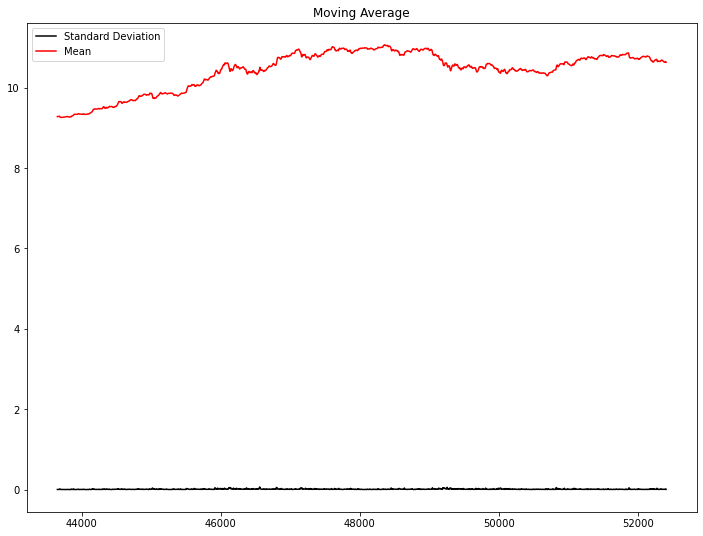

In [90]:
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

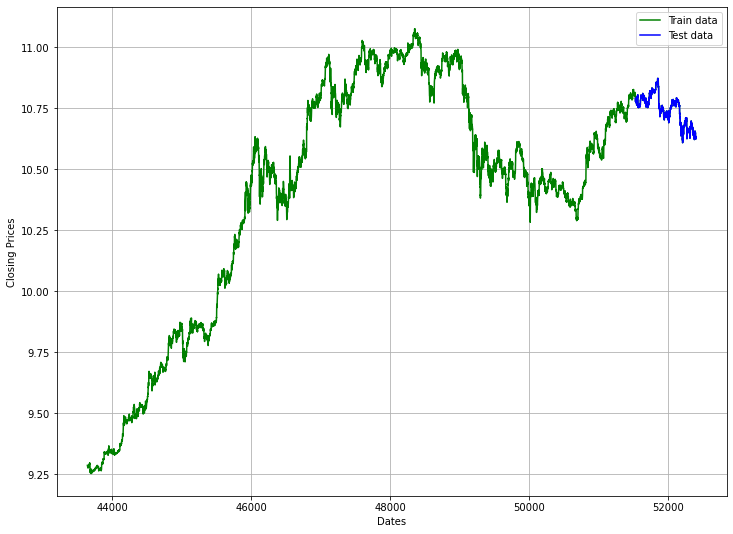

In [91]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [92]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-51121.626, Time=0.93 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-51120.460, Time=0.63 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-51120.509, Time=1.65 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-51120.317, Time=0.31 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-51120.471, Time=4.90 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 8.443 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 7881
Model:               SARIMAX(0, 1, 0)   Log Likelihood               25562.813
Date:                Wed, 13 Oct 2021   AIC                         -51121.626
Time:                        00:04:48   BIC                         -51107.682
Sample:                             0   HQIC                        -51116.849
                               - 7881                             

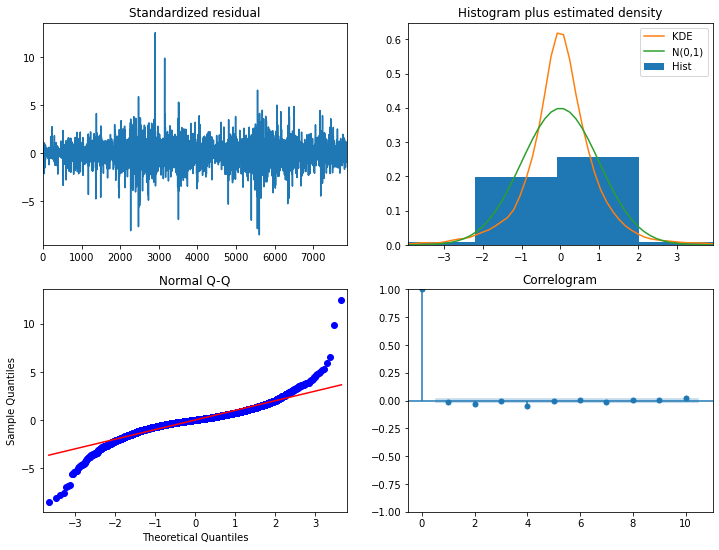

In [93]:
model_autoARIMA.plot_diagnostics()
plt.show()

In [94]:
model = ARIMA(train_data, order=(0, 1, 0))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 7880
Model:                 ARIMA(0, 1, 0)   Log Likelihood               25562.813
Method:                           css   S.D. of innovations              0.009
Date:                Wed, 13 Oct 2021   AIC                         -51121.626
Time:                        00:04:56   BIC                         -51107.682
Sample:                             1   HQIC                        -51116.849
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      1.819      0.069    -1.5e-05       0.000


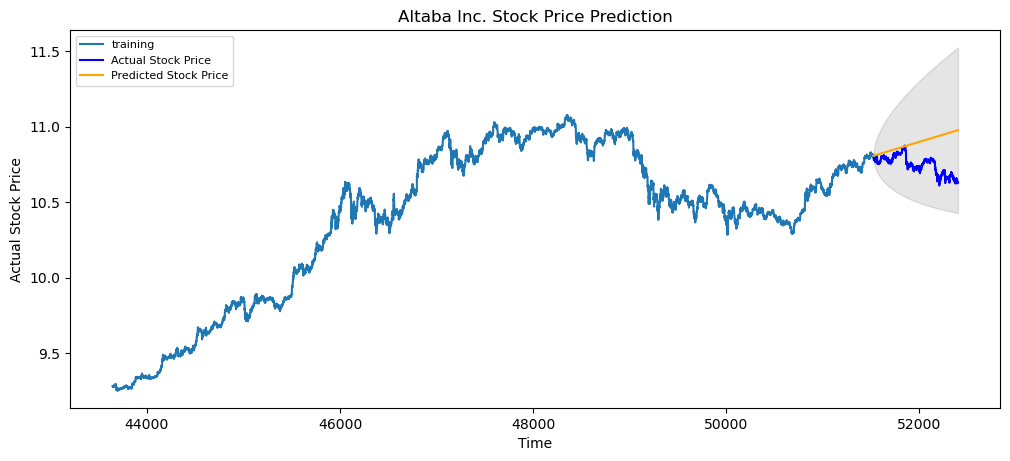

In [96]:
# Forecast
fc, se, conf = fitted.forecast(876, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Altaba Inc. Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [237]:
import scipy

x = [(numDays - dt.datetime(2009,1,9,22,0,0)).days for numDays in btc1D.df['Date']]
y = btc1D.df['Close'] - btc1D.df.iloc[0]['Close']
scipy.optimize.curve_fit(lambda t,a,b: 10**(a * np.log(t) - b),  x,  y)
# y ≈ -26284.65389008 + 7795.67316691 log(x)

(array([ 4.78338136, 35.66448177]),
 array([[0.00746197, 0.06268236],
        [0.06268236, 0.52656092]]))

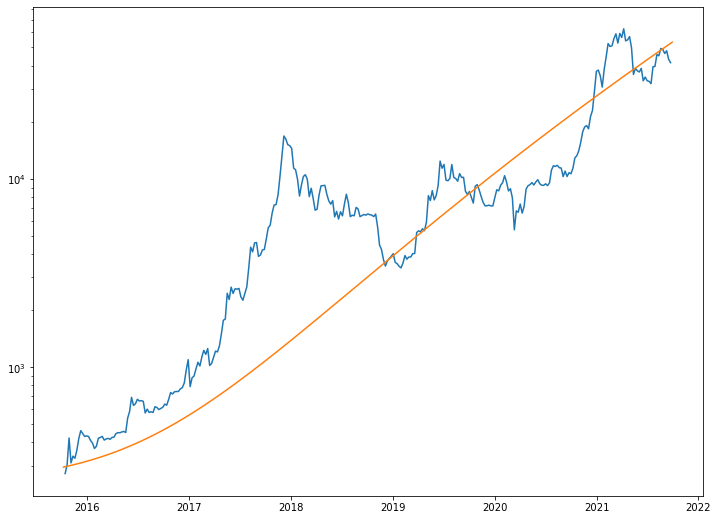

In [239]:
x = [(numDays - dt.datetime(2009,1,9,22,0,0)).days for numDays in btc1D.df['Date']]
y = 10**(4.78338136 * np.log(x) - 35.66448177) + btc1D.df.iloc[0]['Close']
xplot = [dt.datetime(2009,1,9,22,0,0) + dt.timedelta(days=days) for days in x]
plt.plot(btc1W.df.Date, btc1W.df.Close)
plt.yscale('log')
plt.plot(xplot, y)

In [ ]:
### THINGS TO DO
# 1) Regression model
# 2) Change prices to log prices
# 3) Remove variables that have relationships
# 4) Look at relationships between outcome and predictors
# 5) Look at derivatives of some of the indicators
# 6) Try the other signal (Up/Down next candle)

In [275]:
btc1D.randomForest.evaluateAlternateData()

0.47280334728033474

In [384]:
filterReturn

array([0.0003527 , 0.00037848, 0.00040315, ..., 0.00026915, 0.00029799,
       0.00032586])

In [ ]:
price = np.zeros(len(filterReturn))
price[0] = 245.0
for i in range(1, 512):
    price[i] = price[0]*

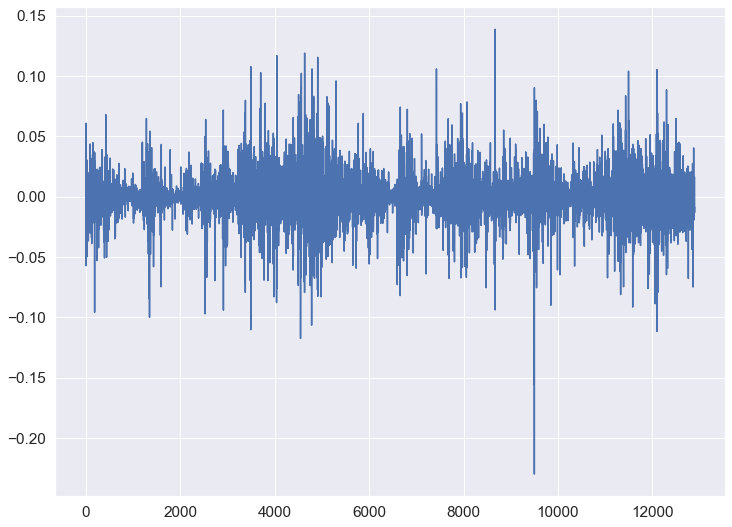

In [411]:
fftClose = np.fft.rfft(np.array(btc4H.analysisData.Return))
#fftClose[32:] = 0.0
filterReturn = np.fft.irfft(fftClose)
#plt.plot(np.sqrt(fftClose*np.conj(fftClose)))
#plt.xlim([0,1500])
#plt.show()

plt.plot(filterReturn)

<AxesSubplot:>

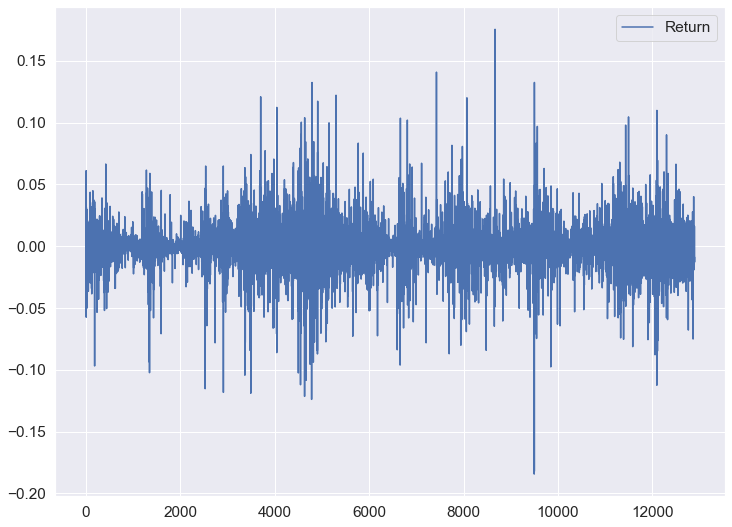

In [389]:
btc4H.analysisData.plot(y='Return')

In [350]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
import seaborn as sns
#pd.options.display.float_format = '{:.5f}'.format
import warnings
import math
import scipy.stats as stats
import scipy
from sklearn.preprocessing import scale
#warnings.filterwarnings('ignore')

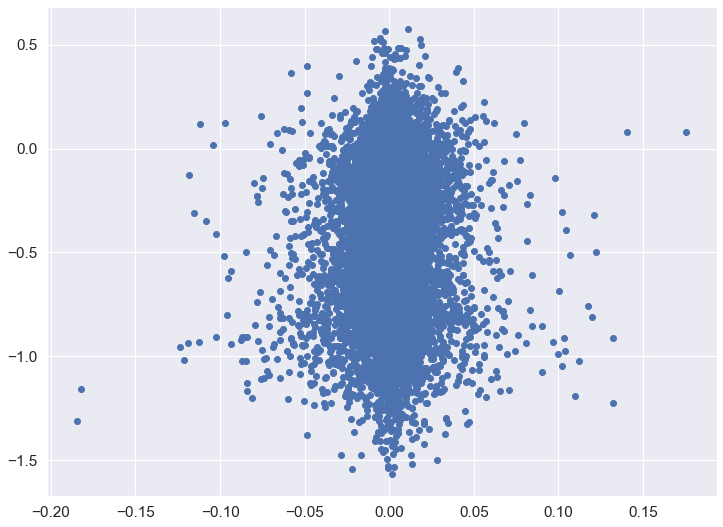

In [525]:
plt.rcParams['figure.figsize'] = 12, 9
plt.scatter(btc4H.analysisData.Return.shift(-1), (btc4H.analysisData['Close'] - btc4H.analysisData['BB-20-2-hi'])/btc4H.analysisData['BB-20-2-width'])

In [232]:
btc4H.randomForest.predictorsTrain

,Close,Volume,Return,logReturn,RSI-14,BB-20-2-hi,BB-20-2-low,BB-20-2-width,RRt,sigmat,...,EMA-100-deviation,SMA-200,dSMA-200dt,d2SMA-200dt2,SMA-200-deviation,EMA-200,dEMA-200dt,d2EMA-200dt2,EMA-200-deviation,Unix Timestamp
4784,11364.15,3197.811076,-0.015903,-0.016031,24.348987,15215.621588,11627.229412,3588.392176,0.088185,0.052995,...,-0.201757,15177.43120,-26.16925,-2.59235,-0.251247,14194.181657,-28.442529,-3.979875,-0.199380,1516111200
6787,3223.41,239.700829,-0.000068,-0.000068,44.456678,3378.609392,3090.772608,287.836784,0.012057,0.007241,...,-0.105833,4165.92540,-15.39205,-0.17235,-0.226244,4141.940400,-9.231461,0.201718,-0.221763,1544954400
10622,10875.81,401.730537,0.007954,0.007922,64.676618,10944.164475,10137.508525,806.655951,0.011733,0.007046,...,0.020010,11187.01535,-2.99325,0.38555,-0.027818,10849.357582,0.265853,3.020546,0.002438,1600189200
4147,4410.57,571.427570,-0.008861,-0.008900,68.474575,4471.351344,4096.302656,375.048687,0.019232,0.011550,...,0.086699,4131.56280,-1.02105,-0.50765,0.067531,4016.675724,3.958736,-0.908268,0.098065,1506938400
9266,9431.57,40.389746,0.000588,0.000588,60.722674,9507.201174,9232.752826,274.448348,0.006785,0.004075,...,0.061999,8368.99570,11.03660,-0.18615,0.126966,8510.289248,9.259103,-0.064037,0.108255,1580662800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6235,6540.00,149.201802,0.001920,0.001918,59.359247,6622.488782,6251.377218,371.111564,0.008560,0.005141,...,-0.004183,6614.37405,1.03380,-0.27035,-0.011244,6667.664808,-1.283063,-0.104983,-0.019147,1537005600
6099,6477.00,617.037910,0.004186,0.004177,51.156084,6723.175568,6221.427432,501.748137,0.018229,0.010948,...,-0.011574,7058.60070,-4.40505,-0.17925,-0.082396,6737.680101,-2.619901,0.256605,-0.038690,1535047200
9864,8769.34,298.605900,0.002647,0.002643,45.124650,9724.274390,8025.711610,1698.562781,0.011407,0.006850,...,0.008185,7909.95720,7.34370,0.70220,0.108646,8202.647518,5.695402,0.008735,0.069087,1589274000
9478,7861.00,456.373919,-0.027892,-0.028288,14.054758,9592.660139,8056.266861,1536.393279,0.040253,0.024178,...,-0.127135,9476.14740,-6.56000,-0.50835,-0.170443,9128.138887,-12.735064,-2.490212,-0.138817,1583715600


In [413]:
#xTrain = sm.add_constant(btc4H.randomForest.predictorsTrain)

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [425]:
results = sm.Logit(btc4H.randomForest.outcomeTrain, btc4H.randomForest.predictorsTrain).fit()

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


         Current function value: inf
         Iterations: 35


LinAlgError: Singular matrix

In [422]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Signal   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     139.3
Date:                Mon, 18 Oct 2021   Prob (F-statistic):           6.09e-32
Time:                        16:48:09   Log-Likelihood:                -7108.5
No. Observations:               10308   AIC:                         1.422e+04
Df Residuals:                   10306   BIC:                         1.424e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              2.4219      0.153     15.852      0.000       2.122       2.721
Unix Timestamp -1.178e-09   9.98e-11    -11.802      0.000   -1.37e-09   -9.83e-10
==============================================================================
Omnibus:                    44386.384   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1654.500
Skew:                          -0.477   Prob(JB):                         0.00
Kurtosis:                       1.285   Cond. No.                     4.92e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.92e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [550]:
output = []
for column in btc1D.randomForest.predictorsTrain:
    xTrain = btc1D.randomForest.predictorsTrain[['RSI-14', 'EMA-20-deviation', 'logReturn', 'Volume', 'd2EMA-5dt2', column]]
    xTrain = sm.add_constant(xTrain)
    results = sm.OLS(btc1D.randomForest.outcomeTrain, xTrain).fit()
    output.append([results.pvalues.index[6], results.pvalues.values[6], results.rsquared])
    
display (pd.DataFrame(output))

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,0,1,2
0,Close,0.915724,0.024023
1,Volume,0.013921,0.024016
2,Return,0.012359,0.027928
3,logReturn,0.001555,0.024016
4,RSI-14,0.000032,0.024016
5,BB-20-2-hi,0.980722,0.024017
6,BB-20-2-low,0.896229,0.024027
7,BB-20-2-width,0.865493,0.024034
8,RRt,0.967282,0.024017
9,sigmat,0.987713,0.024016


In [562]:
    xTrain = btc1D.randomForest.predictorsTrain[['RSI-14', 'EMA-20-deviation', 'logReturn', 'Volume']]
    xTrain = sm.add_constant(xTrain)
    results = sm.OLS(btc1D.randomForest.outcomeTrain, xTrain).fit()
    results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Signal   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     9.017
Date:                Mon, 18 Oct 2021   Prob (F-statistic):           3.36e-07
Time:                        20:18:11   Log-Likelihood:                 2795.4
No. Observations:                1566   AIC:                            -5581.
Df Residuals:                    1561   BIC:                            -5554.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0355      0.009     -4.090      0.000      -0.053      -0.018
RSI-14               0.0007      0.000      4.223      0.000       0.000       0.001
EMA-20-deviation    -0.0819      0.027     -3.042      0.002      -0.135      -0.029
logReturn           -0.0791      0.027     -2.909      0.004      -0.133      -0.026
Volume            6.175e-07   2.43e-07      2.537      0.011     1.4e-07    1.09e-06
==============================================================================
Omnibus:                      342.873   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4982.873
Skew:                          -0.599   Prob(JB):                         0.00
Kurtosis:                      11.656   Cond. No.                     1.74e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.74e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [571]:
testers = btc1D.randomForest.predictorsTest[['RSI-14', 'EMA-20-deviation', 'logReturn', 'Volume']]
testers['Constant'] = 1.0
testers = testers[['Constant', 'RSI-14', 'EMA-20-deviation', 'logReturn', 'Volume']]
testers
results.predict(testers)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1642    0.013912
492     0.017316
445    -0.000415
265     0.003506
1586    0.002636
          ...   
1481    0.004019
286     0.008656
237     0.015796
1605    0.000189
838     0.002755
Length: 175, dtype: float64

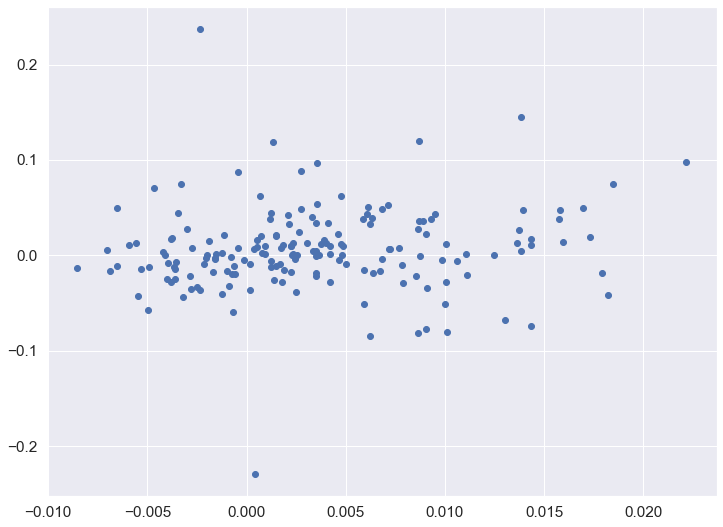

In [575]:
plt.scatter(results.predict(testers), btc1D.randomForest.outcomeTest)

In [348]:
#btc4H.randomForest.predictorsTrain
#btc4H.randomForest.outcome

In [422]:
xTrain = btc4H.randomForest.predictorsTrain[['Volume', 'RSI-14', 'EMA-20-deviation', 'dSMA-5dt', 'logReturn']]
xTrain = sm.add_constant(xTrain, 1)
results = sm.OLS(btc4H.randomForest.outcomeTrain, xTrain).fit()
results.summary()

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Signal   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     20.94
Date:                Tue, 19 Oct 2021   Prob (F-statistic):           6.95e-21
Time:                        20:10:46   Log-Likelihood:                 27779.
No. Observations:               10308   AIC:                        -5.555e+04
Df Residuals:                   10302   BIC:                        -5.550e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0079      0.001     -6.777      0.000      -0.010      -0.006
Volume            7.548e-07   1.81e-07      4.178      0.000    4.01e-07    1.11e-06
RSI-14               0.0002   2.25e-05      6.890      0.000       0.000       0.000
EMA-20-deviation    -0.0611      0.010     -5.896      0.000      -0.081      -0.041
dSMA-5dt          1.388e-05   2.58e-06      5.380      0.000    8.82e-06    1.89e-05
logReturn           -0.0520      0.011     -4.711      0.000      -0.074      -0.030
==============================================================================
Omnibus:                     2367.551   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            76833.844
Skew:                          -0.412   Prob(JB):                         0.00
Kurtosis:                      16.350   Cond. No.                     7.94e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.94e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [431]:
### -0.0079 + 0.0000007548*Volume + 0.0002*RSI-14 - 0.0611*EMA-20-deviation + 0.00001388dSMA-5dt -0.0520logReturn

xTest = sm.add_constant(xTest)
xTest

,const,Volume,RSI-14,EMA-20-deviation,dSMA-5dt,logReturn
5331,1.0,1353.389926,47.926457,-0.013373,-22.492,-0.023820
2816,1.0,464.449945,78.832825,0.035011,2.366,0.009588
1565,1.0,101.493935,51.576564,0.001361,0.006,-0.000380
4399,1.0,3272.176376,51.970019,0.028857,109.252,0.034878
5811,1.0,727.771432,55.848734,0.006338,16.052,-0.000876
...,...,...,...,...,...,...
2932,1.0,299.176367,58.840017,0.024469,2.276,0.000721
11287,1.0,935.714790,51.482108,-0.007804,-482.434,0.002182
128,1.0,44.164814,52.658717,0.005564,0.000,0.031368
8555,1.0,79.615074,34.120311,-0.023997,-22.128,0.003550


In [435]:
xValidate = btc4H.randomForest.validationSet[['Volume', 'RSI-14', 'EMA-20-deviation', 'dSMA-5dt', 'logReturn']]
xValidate = sm.add_constant(xValidate)
predictions = results.predict(xValidate)
#plt.scatter(predictions, btc4H.randomForest.outcomeTest)

In [421]:
output = []
for column in btc4H.randomForest.predictorsTrain:
    xTrain = btc4H.randomForest.predictorsTrain[['Volume', 'RSI-14', 'EMA-20-deviation', 'dSMA-5dt', 'logReturn', column]]
    xTrain = sm.add_constant(xTrain)
    results = sm.OLS(btc4H.randomForest.outcomeTrain, xTrain).fit()
    output.append([results.pvalues.index[6], results.pvalues.values[6], results.rsquared])
    
display (pd.DataFrame(output, columns=['Variable','P-Value','R-Squared']).sort_values(by='R-Squared', ascending=False))

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,Variable,P-Value,R-Squared
2,Return,2.457694e-05,0.011769
23,dEMA-10dt,4.238884e-04,0.011253
12,d2SMA-5dt2,7.671988e-03,0.010743
13,SMA-5-deviation,1.214428e-02,0.010664
15,dEMA-5dt,1.541489e-02,0.010624
31,dEMA-20dt,1.841102e-02,0.010594
19,dSMA-10dt,5.614497e-02,0.010411
17,EMA-5-deviation,1.047995e-01,0.010313
52,d2SMA-200dt2,1.598426e-01,0.010250
29,SMA-20-deviation,1.616231e-01,0.010248


In [360]:
xTest = btc4H.randomForest.predictorsTest
xTest = sm.add_constant(xTest, 245)
predictions = results.predict(xTest)

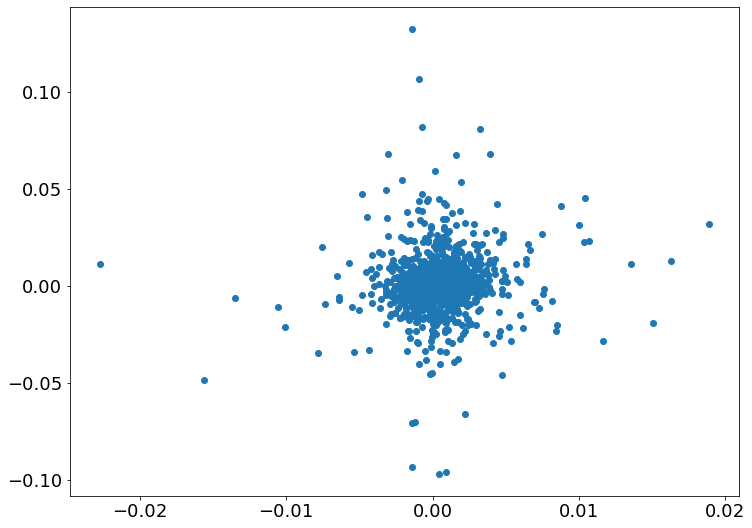

In [362]:
plt.scatter(predictions, btc4H.randomForest.outcomeTest)

In [436]:
predictions

11454    0.003354
11455    0.002427
11456    0.002971
11457    0.000654
11458   -0.001903
           ...   
12892    0.000109
12893    0.000980
12894    0.002210
12895   -0.000328
12896   -0.000998
Length: 1443, dtype: float64

In [374]:
btc4H.randomForest.validationSet

,Close,Volume,Return,logReturn,RSI-14,BB-20-2-hi,BB-20-2-low,BB-20-2-width,RRt,sigmat,...,EMA-100-deviation,SMA-200,dSMA-200dt,d2SMA-200dt2,SMA-200-deviation,EMA-200,dEMA-200dt,d2EMA-200dt2,EMA-200-deviation,Unix Timestamp
11454,33804.96,228.591280,-0.019831,-0.020030,51.470494,36682.197614,31788.838386,4893.359229,0.032211,0.019346,...,0.006646,34259.41965,29.52840,-10.80605,-0.013265,32413.403416,13.985493,-22.796293,0.042932,1612170000
11455,33454.26,532.744260,-0.010374,-0.010428,49.390385,36357.192568,31824.853432,4532.339136,0.026864,0.016134,...,-0.003722,34288.09575,28.67610,3.08250,-0.024319,32423.760198,10.356782,-0.243096,0.031782,1612184400
11456,33875.78,497.865987,0.012600,0.012521,51.906229,35310.522747,32465.522253,2845.000494,0.020364,0.012230,...,0.008655,34318.23450,30.13875,3.77760,-0.012893,32438.208157,14.447958,11.811064,0.044317,1612198800
11457,33796.10,274.514189,-0.002352,-0.002355,51.386217,34774.282987,32772.282013,2002.000974,0.021257,0.012767,...,0.006157,34346.48140,28.24690,-5.24635,-0.016024,32451.719518,13.511362,-5.964369,0.041427,1612213200
11458,33916.23,208.744961,0.003555,0.003548,52.164312,34663.637441,32812.299559,1851.337883,0.013752,0.008259,...,0.009539,34372.14445,25.66305,-3.27585,-0.013264,32466.291762,14.572244,3.058361,0.044660,1612227600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12892,42258.35,279.173200,0.016165,0.016036,46.406584,44362.845565,40973.510435,3389.335130,0.026483,0.015906,...,-0.047612,46548.77850,-23.84805,6.45505,-0.092171,45139.563688,-28.956921,15.646330,-0.063829,1632877200
12893,42368.65,99.209377,0.002610,0.002607,47.426158,44356.269748,40957.268252,3399.001496,0.011319,0.006798,...,-0.044272,46524.25255,-24.52595,-4.18435,-0.089321,45111.992408,-27.571280,-4.275823,-0.060812,1632891600
12894,42041.13,171.732666,-0.007730,-0.007760,44.706438,44358.262242,40936.033758,3422.228484,0.017628,0.010587,...,-0.050689,46499.83300,-24.41955,0.89070,-0.095886,45081.436563,-30.555845,-7.354770,-0.067440,1632906000
12895,41499.01,278.415220,-0.012895,-0.012979,40.560248,44367.541595,40914.569405,3452.972190,0.020167,0.012112,...,-0.061761,46471.41500,-28.41800,-8.10330,-0.106999,45045.790527,-35.646035,-7.195817,-0.078737,1632920400


In [381]:
xValidate = btc4H.randomForest.validationSet
xValidate = sm.add_constant(xValidate)
predictions = results.predict(xValidate)

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


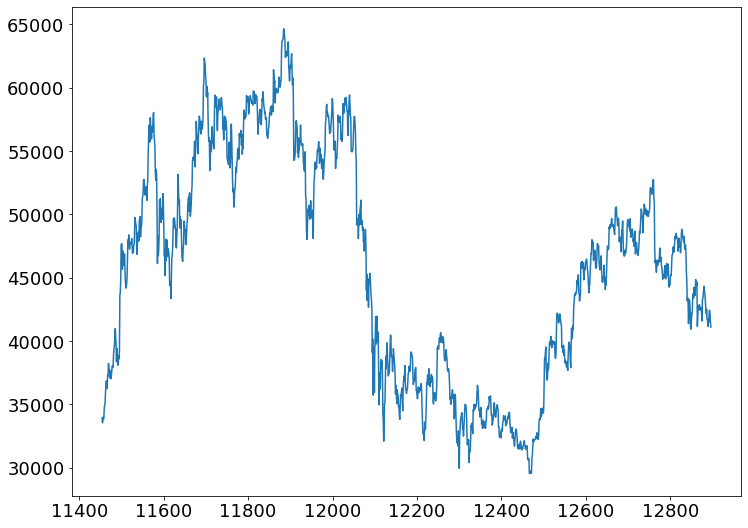

In [437]:
plt.plot(btc4H.randomForest.validationSet.Close * (1+predictions))

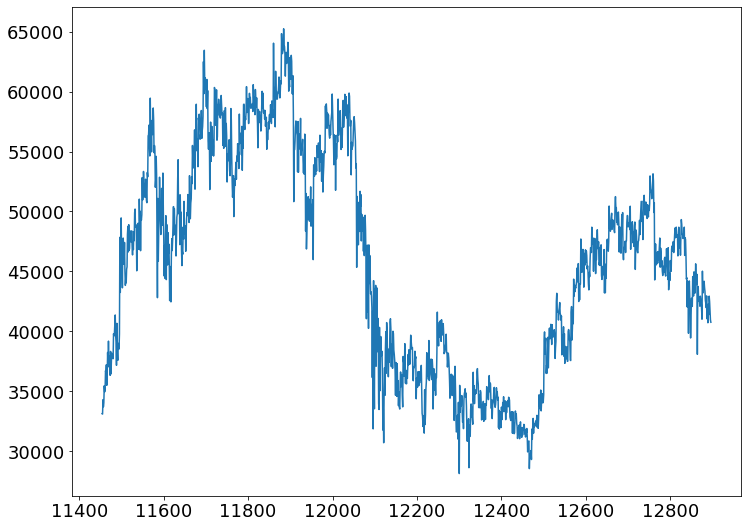

In [387]:
plt.plot(btc4H.randomForest.validationSet.Close * (1+btc4H.randomForest.validationSet.Return))

In [438]:
predictions

11454    0.003354
11455    0.002427
11456    0.002971
11457    0.000654
11458   -0.001903
           ...   
12892    0.000109
12893    0.000980
12894    0.002210
12895   -0.000328
12896   -0.000998
Length: 1443, dtype: float64

In [444]:
btc4H.randomForest.validationSet.Close.values

array([33804.96, 33454.26, 33875.78, ..., 42041.13, 41499.01, 41129.26])

In [439]:
predictionsStep = predictions + 1

In [440]:
predictionsStep

11454    1.003354
11455    1.002427
11456    1.002971
11457    1.000654
11458    0.998097
           ...   
12892    1.000109
12893    1.000980
12894    1.002210
12895    0.999672
12896    0.999002
Length: 1443, dtype: float64

In [441]:
pricePredictions = [33804.96]
for multiplier in predictionsStep:
    pricePredictions.append(pricePredictions[-1]*multiplier)

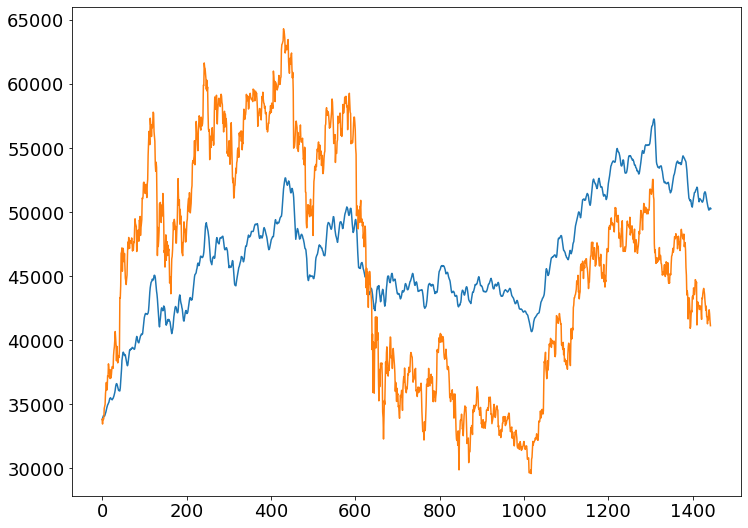

In [445]:
plt.plot(pricePredictions)
plt.plot(btc4H.randomForest.validationSet.Close.values)

In [450]:
predictionsStep[predictionsStep < 1.01]

11454    1.003354
11455    1.002427
11456    1.002971
11457    1.000654
11458    0.998097
           ...   
12892    1.000109
12893    1.000980
12894    1.002210
12895    0.999672
12896    0.999002
Length: 1423, dtype: float64